# Transition in the Huggett economy

**Table of contents**<a id='toc0_'></a> 
- 1. [Solve for a transition in the Huggett economy](#toc1_)
	- 1.1. [Parameters](#toc1_1_)
	- 1.2. [Income State Space](#toc1_2_)
	- 1.3. [Solving for initial and final steady states](#toc1_3_)
	- 1.4. [Policy Path](#toc1_4_)
	- 1.5. [Initial Guess for path of interest rate](#toc1_5_)
	- 1.6. [Interest Rate Path](#toc1_6_)
	

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import Toolkit as tk
import pickle

## 1. <a id='toc1_1_'></a>[Parameters](#toc1_1_)

In [2]:
## Parameters
beta = 0.993362
gamma = 1.5
eis = 1/gamma
a_under_pre = -4
a_under_post = -6
a_bar = 10

Transition = 25  ### Transition period
T = 100  ### Total period
A_bar = 0 ### Supply of asset


## Grids
n_a = 100
n_e = 2

## 1.2. <a id='toc1_2_'></a>[Income State Space](#toc1_2_)

In [3]:
y_grid = np.array([0.1, 1.0])
Pi = np.array([[0.5, 0.5], [0.075, 0.925]])

## 1.3. <a id='toc1_3_'></a>[Solving for initial and final steady states](#toc1_3_)

In [4]:
a_grid_0 = tk.discretize_assets_single_exp(a_under_pre, a_bar, n_a)
a_grid_1 = tk.discretize_assets_single_exp(a_under_post, a_bar, n_a)

r_min = -1
r_max = 1/beta - 1

r_0 , g_0 , c_0 , dist_0 = tk.steady_state(a_grid_0, y_grid, Pi, beta, eis, A_bar, r_min, r_max)
r_1 , g_1 , c_1 , dist_1 = tk.steady_state(a_grid_1, y_grid, Pi, beta, eis, A_bar, r_min, r_max)

## 1.4. <a id='toc1_4_'></a>[Policy Path](#toc1_4_)

We suppose that the policy change is done linearly over time, between 0 to 25.

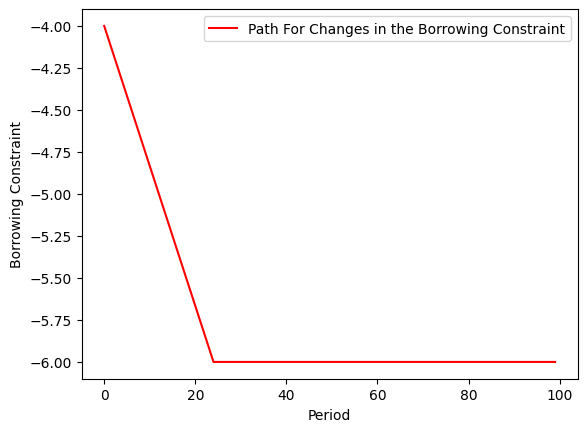

In [5]:
Policy_path = np.zeros((T))
# Policy_path[0:Transition] = [(1/24**2)*t**2 - 3/24 * t - 4 for t in range(Transition)]
# Policy_path[Transition:] = a_under_post
Policy_path[0:Transition] = np.linspace(a_under_pre, a_under_post, Transition)
Policy_path[Transition:] = a_under_post
plt.plot(np.arange(T), Policy_path, 'r', label = 'Path For Changes in the Borrowing Constraint')
plt.xlabel('Period')
plt.ylabel('Borrowing Constraint')
plt.legend()
plt.show()

## 1.5. <a id='toc1_5_'></a>[Initial Guess for path of interest rate](#toc1_5_)

Our Initial guess is that the interest rate increases linearly over time to reach to the new steady state level
at time $T = 100$.

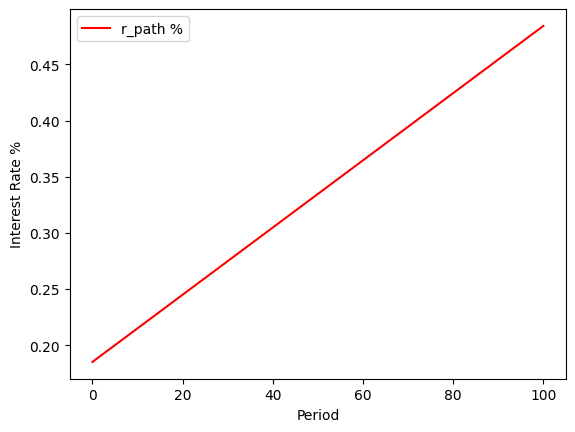

In [140]:
r_path = np.linspace(r_0, r_1, T + 1)
plt.plot(np.arange(T+1), r_path*100, 'r', label = 'r_path %')
plt.xlabel('Period')
plt.ylabel('Interest Rate %')
plt.legend()
plt.show()

r_path is the path for r which is in dimension (101). At 0 and 100, it is equal to the initial and final levels of interest rate.

Demand is in dimension (100). Demand for time 0 is not updated as it is equal to 0. We only update demand at t = 1 till 99.

In [141]:
### Full policy matrix for all periods and states. Notice that at time 0, the policy is the initial steady state policy.
Policy = np.zeros((n_e, n_a, T)) 
Policy[:,:,0] = g_0

### Full asset grid for all periods. Notice that at time 0, the asset grid is the initial steady state asset grid.
a_grid_total = np.zeros((n_a, T))
a_grid_total[:,0] = a_grid_0

### Full distribution matrix for all periods and states. Notice that at time 0, the distribution is the initial steady state distribution.
dist_total = np.zeros((n_e, n_a, T))
dist_total[:,:,0] = dist_0

### Full demand for all periods. Notice that at time 0, the demand is the initial steady state demand, which is indeed 0.
demand = np.zeros((T))
demand[0] = np.sum(dist_0 * a_grid_0)

for t in range(1,T):
    a_grid_total[:,t] = tk.discretize_assets_single_exp(Policy_path[t], a_bar, n_a)

In [ ]:
### Change in interest rate. The updating rule.
change_r = 1E-6

### Asset Supply for all periods, which is constant (and for this case, zero).
A_bar_total = np.full((T), A_bar)

### Iteration
diff = 1
#temp_diff = diff
while diff > 1E-3:
    # if np.abs(diff - temp_diff)/diff < 1E-4:
    #     change_r = change_r / 10
    #     print('Change in r is too large, change_r is now', change_r)
    # temp_diff = diff

    #### Backward Iteratioon to get the policy function
    for i in range(1,T):
        t = T - i
        r = r_path[t]
        Va, g, c = tk.policy_ss(Pi, a_grid_total[:,t], y_grid, r, beta, eis, tol=1E-9)
        Policy[:,:,t] = g

    #### Forward Iteration to get the distribution
    for t in range(1,T):
        g = Policy[:,:,t]
        a_grid = a_grid_total[:,t]
        index_k, alpha = tk.get_lottery(g, a_grid)
        dist_total[:,:,t] = tk.forward_iteration(dist_total[:,:,t-1], index_k, alpha, Pi)
        demand[t] = np.sum(dist_total[:,:,t] * g)
    
    diff = np.max(np.abs(demand[1:] - A_bar_total[1:]))
    print("maximum excess demand is: ", diff, sep = ':')
    
    r_path[1:-1] = r_path[1:-1] - change_r * np.sign(demand[1:])


## 1.6. <a id='toc1_6_'></a>[Interest Rate Path](#toc1_6_)

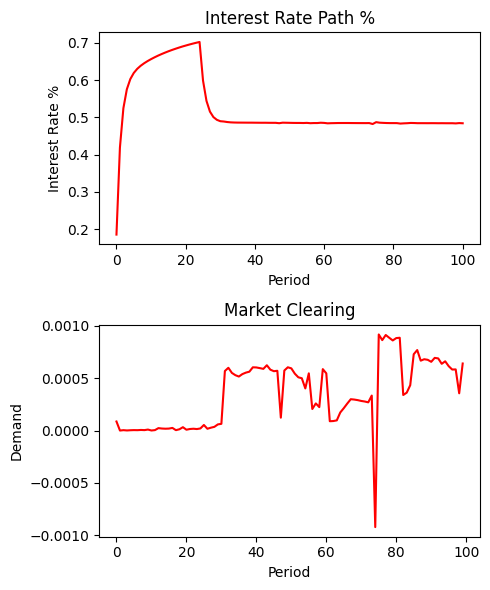

In [39]:
# plt.plot(np.arange(T+1), r_path*100, 'r', label = 'r_path %')
# plt.xlabel('Period')
# plt.ylabel('Interest Rate %')
# plt.legend()
# plt.show()

fig, axes = plt.subplots(2, figsize=(5, 6))

# Plot in the first subplot (top-left)
axes[0].plot(np.arange(T+1), r_path*100, 'r', label = 'r_path %')
axes[0].set_title('Interest Rate Path %')
axes[0].set_xlabel('Period')
axes[0].set_ylabel('Interest Rate %')


# Plot in the third subplot (bottom-left)
axes[1].plot(np.arange(T), demand, 'r', label = 'Market Clearing')
axes[1].set_title('Market Clearing')
axes[1].set_xlabel('Period')
axes[1].set_ylabel('Demand')


# Add some space between subplots
plt.tight_layout()

# Show the subplots
plt.show()

## Saving the Data for later use

In [40]:
data = {'Policy': Policy, 'dist_total': dist_total, 'demand': demand, 'r_path': r_path}
# data_file = open('data.pkl', 'wb')
# pickle.dump(data, data_file)

In [41]:
### I want to load from a pickle file
data_file = open('data.pkl', 'rb')
data = pickle.load(data_file)

## Solving for the Value function at t = 1

For welfare analysis, we first need to solve for the value function at 1.

In [142]:
r_path = data['r_path']
Policy = data['Policy']

In [143]:
### First, let's solve value at the final steady state

Value_final = np.zeros((n_e, n_a))
for i in range(n_e):
    for j in range(n_a):
        for t in range(10000):
            Value_final[i,j] += beta**t * c_1[i,j]**(1-gamma)/(1-gamma)

Value_initial = np.zeros((n_e, n_a))
for i in range(n_e):
    for j in range(n_a):
        for t in range(10000):
            Value_initial[i,j] += beta**t * c_0[i,j]**(1-gamma)/(1-gamma)

In [144]:
Value_full = np.zeros((n_e, n_a, T+1))
Value_full[:,:,-1] = Value_final
Value_full[:,:,0] = Value_initial
for i in range(1,T):
    t = T - i
    Value_full[:,:,t] = (1+r_path[t])*a_grid_total[:,t][np.newaxis,:] + y_grid[:,np.newaxis] - Policy[:,:,t] + beta * Pi @ Value_full[:,:,t+1]

In [145]:
alpha = (Value_full[:,:,1]/Value_full[:,:,0])**(1/(1-gamma)) - 1

In [146]:
print("average consumption gain", sum(sum(dist_0*alpha)), sep = ':')

average consumption gain:7.687759035928241
